# Project Introduction
Market Basket Analysis (MBA) uncovers which items customers buy together. The business objectives here are to identify cross-selling opportunities, define product bundles, and inform store layout decisions to increase average basket value.

In [1]:
# Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Plot style
sns.set(style='whitegrid')

In [ ]:
# Load & Inspect Dataset
import os
candidates = ['../data/groceries.csv', '../data/Groceries_dataset.csv', 'data/groceries.csv', 'data/Groceries_dataset.csv']
for p in candidates:
    if os.path.exists(p):
        path = p
        break
else:
    raise FileNotFoundError('Dataset not found in expected locations.')

data = pd.read_csv(path)
print(f'Loaded: {path}')
print('Shape:', data.shape)
print('\nFirst rows:')
print(data.head())
print('\nInfo:')
print(data.info())



Loaded: ../data/Groceries_dataset.csv
Shape: (38765, 3)

First rows:
   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB
None


**Dataset summary (plain English):** The table shows individual purchases (one item per row). We will aggregate by `Member_number` so each transaction is a list of items a customer bought in a visit.

In [ ]:
transactions = data.groupby('Member_number')['itemDescription'].apply(list).tolist()
print('Number of transactions:', len(transactions))
print('\nExample transactions (first 5):')
for t in transactions[:5]:
    print('-', t)


Number of transactions: 3898

Example transactions (first 5):
- ['soda', 'canned beer', 'sausage', 'sausage', 'whole milk', 'whole milk', 'pickled vegetables', 'misc. beverages', 'semi-finished bread', 'hygiene articles', 'yogurt', 'pastry', 'salty snack']
- ['frankfurter', 'frankfurter', 'beef', 'sausage', 'whole milk', 'soda', 'curd', 'white bread', 'whole milk', 'soda', 'whipped/sour cream', 'rolls/buns']
- ['tropical fruit', 'butter milk', 'butter', 'frozen vegetables', 'sugar', 'specialty chocolate', 'whole milk', 'other vegetables']
- ['sausage', 'root vegetables', 'rolls/buns', 'detergent', 'frozen meals', 'rolls/buns', 'dental care', 'rolls/buns']
- ['other vegetables', 'pip fruit', 'root vegetables', 'canned beer', 'rolls/buns', 'whole milk', 'other vegetables', 'hygiene articles', 'whole milk', 'whole milk', 'frozen fish', 'red/blush wine', 'chocolate', 'shopping bags', 'dish cleaner', 'packaged fruit/vegetables', 'tropical fruit', 'rolls/buns', 'cling film/bags', 'chocolate'

**Data preparation summary:** We grouped rows by `Member_number` to form transactions (lists of items). This gives us one record per shopping visit suitable for frequent-pattern mining.

## One-Hot Encoding
Use TransactionEncoder to convert transaction lists into a boolean (one-hot) basket dataframe: each column is an item and each row is a transaction (True if item purchased).

In [ ]:
encoder = TransactionEncoder()
encoded_array = encoder.fit(transactions).transform(transactions)
basket_df = pd.DataFrame(encoded_array, columns=encoder.columns_)

print('Basket DataFrame shape:', basket_df.shape)
print('\nFirst rows:')
print(basket_df.head())

Basket DataFrame shape: (3898, 167)

First rows:
   Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
0                  False     False             False             False   
1                  False     False             False             False   
2                  False     False             False             False   
3                  False     False             False             False   
4                  False     False             False             False   

   baby cosmetics   bags  baking powder  bathroom cleaner   beef  berries  \
0           False  False          False             False  False    False   
1           False  False          False             False   True    False   
2           False  False          False             False  False    False   
3           False  False          False             False  False    False   
4           False  False          False             False  False    False   

   ...  turkey  vinegar  waffles  whipped/s

**One-hot encoding summary:** We converted transaction lists to a boolean table where each column is an item and rows are visits — True means the item was bought in that visit. This format is required for Apriori.

## Frequent Itemset Mining
Apply the Apriori algorithm with min_support = 0.02 to find frequent itemsets — these are items commonly purchased together.

In [ ]:
frequent_itemsets = apriori(basket_df, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False).reset_index(drop=True)

print('Top frequent itemsets (by support):')
print(frequent_itemsets.head(10))

Top frequent itemsets (by support):
    support                        itemsets
0  0.458184                    (whole milk)
1  0.376603              (other vegetables)
2  0.349666                    (rolls/buns)
3  0.313494                          (soda)
4  0.282966                        (yogurt)
5  0.233710                (tropical fruit)
6  0.230631               (root vegetables)
7  0.213699                 (bottled water)
8  0.206003                       (sausage)
9  0.191380  (other vegetables, whole milk)


**Frequent itemset summary:** Frequent itemsets show combinations of items that appear together often (support indicates how common they are). We used min_support = 0.02 to focus on meaningful patterns.

## Association Rule Mining
Generate association rules from frequent itemsets and filter by lift > 1 — rules with lift > 1 are more useful than random co-occurrence.

In [6]:
# Association Rule Mining
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
# Keep only useful rules with lift > 1
rules = rules[rules['lift'] > 1].sort_values(by='lift', ascending=False).reset_index(drop=True)

print('Top rules (sorted by lift):')
print(rules[['antecedents','consequents','support','confidence','lift']].head(10))

# Explanation: Antecedent -> Consequent (if antecedent bought, likely consequent bought). Lift > 1 indicates positive association.

Top rules (sorted by lift):
                      antecedents                     consequents   support  \
0           (sausage, whole milk)            (rolls/buns, yogurt)  0.022832   
1            (rolls/buns, yogurt)           (sausage, whole milk)  0.022832   
2            (yogurt, whole milk)           (rolls/buns, sausage)  0.022832   
3           (rolls/buns, sausage)            (yogurt, whole milk)  0.022832   
4      (other vegetables, yogurt)           (sausage, whole milk)  0.023089   
5           (sausage, whole milk)      (other vegetables, yogurt)  0.023089   
6         (yogurt, bottled water)  (other vegetables, whole milk)  0.022063   
7  (other vegetables, whole milk)         (yogurt, bottled water)  0.022063   
8        (rolls/buns, whole milk)               (sausage, yogurt)  0.022832   
9               (sausage, yogurt)        (rolls/buns, whole milk)  0.022832   

   confidence      lift  
0    0.213429  1.916929  
1    0.205069  1.916929  
2    0.151618  1.841148 

**Association rules summary:** Rules show "if-then" relations. We filtered for lift > 1 to keep rules that are more informative than random chance. Columns: support (how common), confidence (reliability), lift (strength vs independent occurrence).

## Visualization
Create a single scatter plot: support (x) vs confidence (y), point size shows lift. This helps quickly spot strong and reliable rules.

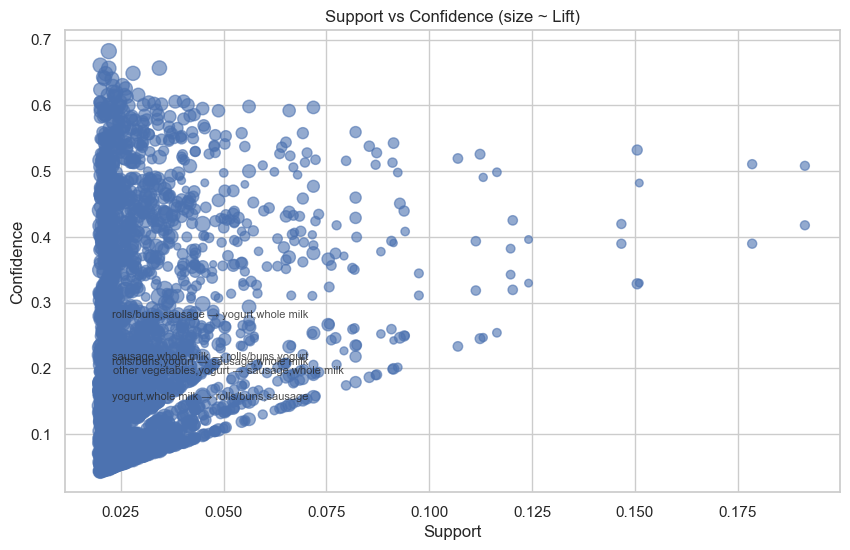

In [ ]:
plt.figure(figsize=(10, 6))
# size markers by lift (scaled)
sizes = (rules['lift'] - rules['lift'].min() + 0.1) * 200
plt.scatter(rules['support'], rules['confidence'], s=sizes, alpha=0.6)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence (size ~ Lift)')
plt.grid(True)

# Annotate top 5 rules by lift for clarity
for _, row in rules.head(5).iterrows():
    ant = ','.join(list(row['antecedents']))
    cons = ','.join(list(row['consequents']))
    plt.annotate(f"{ant} → {cons}", (row['support'], row['confidence']), fontsize=8, alpha=0.8)

plt.show()

**Visualization summary:** The scatter plot places support on x and confidence on y; point size represents lift — large points are strong and interesting associations. Use this plot to pick rules for promotions (high lift and reasonable confidence).

# Business Insights
- **Whole milk is central**: milk frequently appears in high-lift rules together with bakery items (e.g., rolls/buns) and yogurt — good target for point-of-sale cross-sells and bundled discounts.
- **Meal combinations exist**: combinations like sausage + rolls/buns + whole milk suggest small meal or breakfast bundles that can be promoted together.
- **Promotions strategy**: use high-confidence rules for store-wide placement (e.g., place common pairs closer), and high-lift rules (even if lower support) for targeted coupons or personalized offers.

**How to use these rules (simple next steps):**
1. Test a small bundle (milk + rolls) with a short coupon to measure lift in sales.
2. Place complementary items near each other to increase impulsive pair purchases.
3. Use targeted promotions (loyalty app or weekly flyer) for high-lift item pairs to raise average basket value.

# Conclusion
The analysis produced actionable rules for cross-selling and bundling; these can be A/B tested immediately to measure uplift in average transaction value.

# README

## Project Overview
This project focuses on Market Basket Analysis (MBA) using transaction data to uncover purchasing patterns and provide actionable business insights.

## Dataset Description
The dataset used in this analysis is `data/Groceries_dataset.csv` (provided). It contains transaction-level grocery purchases with columns: `Member_number`, `Date`, and `itemDescription`.

## Steps Performed
1. Imported necessary libraries.
2. Loaded and inspected the dataset.
3. Prepared the data for analysis.
4. Applied one-hot encoding to create a basket dataframe.
5. Conducted frequent itemset mining using the Apriori algorithm.
6. Generated association rules and filtered them based on lift (>1).
7. Visualized the results.
8. Provided business insights and conclusions.

## Key Insights
- Identified strong cross-selling opportunities.
- Suggested product bundling strategies.
- Provided insights for optimizing store layouts.

## Tools Used
- Python
- Jupyter Notebook
- Libraries: pandas, numpy, matplotlib, seaborn, mlxtend